In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, splev, BSpline
import sys
sys.path.append('../')
from package_global_functions import *
from filesHandling_quenched import *
from percolationAnalysis import getMeanClusterSize_ir

In [3]:
def meanClusterSize_w_splines(arena_r, exclusion_r, Ns, around_maxs, ss, push = False):
    pushLabel = 'push' if push else 'nopush'
    fig, ax = plt.subplots()
    colors = plt.cm.gnuplot(np.linspace(0,0.95,len(Ns)))
    percs_from_spline = []
    ax.set(xlabel=r'$r_{int}$', ylabel='MCS')
    zipper = zip(Ns, ss, around_maxs, colors, arena_r) if isinstance(arena_r, list) else zip(Ns, ss, around_maxs, colors)
    # for N,s,around_max,color in zip(Ns, ss, around_maxs, colors):
    for z in zipper:
        if isinstance(arena_r, list):
            N,s,around_max,color,ar = z
        else:
            N,s,around_max,color = z
            ar = arena_r
        irs = availableIrs(N, ar, exclusion_r, push)
        dfmcs = getMeanClusterSize_ir(N, ar, exclusion_r, irs, push)
        ax.plot(dfmcs['interac_r'], dfmcs['mcs'], label=f'{N}', marker='.', lw=0.4, color=color, alpha=0.5)
        maxMCS = max(dfmcs['mcs'])
        i = dfmcs[dfmcs.mcs == maxMCS].index[0]
        irs_spline, mcs_spline = np.array(dfmcs.iloc[i-around_max:i+around_max+1].interac_r), np.array(dfmcs.iloc[i-around_max:i+around_max+1].mcs)
        tck_s = splrep(irs_spline, mcs_spline, s=s)
        ax.plot(irs_spline, BSpline(*tck_s)(irs_spline), '-', color=color)
        irs_interp = np.linspace(irs_spline[0],irs_spline[-1],500)
        mcs_interp = splev(irs_interp,tck_s)
        maxMCS = max(mcs_interp)
        index_maxMCS = max(range(len(mcs_interp)), key=mcs_interp.__getitem__)
        perc_ir = irs_interp[index_maxMCS]
        percs_from_spline.append(perc_ir)
    fig.legend(title='N', fontsize=8)
    fig.tight_layout()
    fig.savefig(f'MCS_difN_ar_{arena_r}_er_{exclusion_r}_{pushLabel}_splineMAX.png')
    return percs_from_spline

def ri_star_N_fit(arena_r, exclusion_r, Ns, percs_from_spline, func, p0in = None, push = False, logscale = False, eyerule=1.0):
    from scipy.optimize import curve_fit
    pushLabel = 'push' if push else 'nopush'
    paramfit, covfit = curve_fit(func, Ns, percs_from_spline, p0=p0in)
    fit = func(Ns, *paramfit)
    fig, ax = plt.subplots()
    ax.plot(Ns, percs_from_spline, marker='.', lw=0.7)
    ax.plot(Ns, fit, ls='-.', lw=0.8, color='k')
    ax.plot(Ns, eyerule*np.array(Ns)**(-1/2), ls='-.', color='xkcd:red', lw=0.9)
    ax.text(0.6, 0.6, rf'{round(paramfit[0],3)} N**({round(paramfit[1],3)})', fontsize=8, color='k', transform=ax.transAxes)
    ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
    ax.set(xlabel='N', ylabel=r'$r_{int}^{*}$')
    fig.tight_layout()
    figname = f'percR_MCS_difN_ri_star_N_fit_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
    if logscale:
        figname += '_logscale'
    figname += '_from_splineMAX.png'
    fig.savefig(figname)
    return paramfit

def p_star_FSC_check(arena_r, exclusion_r, Ns, percs_from_spline, func, p0in = None, push = False, logscale = False):
    from scipy.optimize import curve_fit
    pushLabel = 'push' if push else 'nopush'
    # Finite size scaling
    nu, df = 4/3, 182/96
    Ns_fsc = np.array(Ns)**(-1/(nu*df))
    if isinstance(arena_r, list):
        y_axis = [N*(ri_star/ar)**2 for N,ri_star,ar in zip(Ns,percs_from_spline, arena_r)]
    else:
        y_axis = [N*(ri_star/arena_r)**2 for N,ri_star in zip(Ns,percs_from_spline)]
    paramfit, covfit = curve_fit(func, Ns_fsc, y_axis, p0=p0in)
    fit = func(Ns_fsc, *paramfit)
    fig, ax = plt.subplots()
    ax.plot(Ns_fsc, y_axis, marker='.', lw=0.7)
    ax.plot(Ns_fsc, fit, ls='-.', lw=0.8, color='k')
    ax.text(0.6, 0.40, rf'${round(paramfit[0],3)}*N^{{-1/(\nu d_f)}} + {round(paramfit[1],3)}$', fontsize=8, color='k', transform=ax.transAxes)
    # ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
    ax.set(xlabel=r'$N^{-1/(\nu d_f)}$', ylabel=r'$N(r_{int}^* / R)^2$') # , xscale='log', yscale='log'
    fig.tight_layout()
    figname = f'percR_MCS_difN_p_star_Nexpos_check_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
    if logscale:
        figname += '_logscale'
    figname += '_from_splineMAX_FSC.png'
    fig.savefig(figname)

def p_star_FSC_fit(arena_r, exclusion_r, Ns, percs_from_spline, func, p0in = None, push = False):
    from scipy.optimize import curve_fit
    pushLabel = 'push' if push else 'nopush'
    # Finite size scaling theoretical parameters
    nu, df = 4/3, 182/96
    # expected exponents:
    exp = -1/(nu*df)
    # print(f'Expected exponent: {exp}')
    if isinstance(arena_r, list):
        y_axis = [N*(ri/ar)**2 for N,ri,ar in zip(Ns,percs_from_spline,arena_r)]
    else:
        y_axis = [N*(ri/arena_r)**2 for N,ri in zip(Ns,percs_from_spline)]
    paramfit, covfit = curve_fit(func, Ns, y_axis, p0 = p0in)
    fit = func(Ns, *paramfit)
    fig, ax = plt.subplots()
    ax.plot(Ns, y_axis, marker='.', lw=0.7)
    ax.plot(Ns, fit, ls='-.', lw=0.8, color='k')
    ax.text(0.6, 0.45, rf'${round(paramfit[0],3)}*N^{{{round(paramfit[1],3)}}} + {round(paramfit[2],3)}$', fontsize=8, color='k', transform=ax.transAxes)
    # ax.text(0.6, 0.55, rf'{round(paramfit[1],8)} +- {round(np.sqrt(covfit[1,1]),8)}', fontsize=8, color='k', transform=ax.transAxes)
    ax.text(0.4, 0.55, fr'expected exponent $-1/ \nu d_f = {round(-1/(nu * df), 5)}$', fontsize = 8, color='k', transform=ax.transAxes)
    ax.set(xlabel=r'$N$', ylabel=r'$N (r_{int}^* / R)^2$') # , xscale='log', yscale='log'
    fig.tight_layout()
    figname = f'percR_MCS_difN_p_star_Nexpos_fit_ar_{arena_r}_er_{exclusion_r}_{pushLabel}'
    figname += '_from_splineMAX_FSC.png'
    fig.savefig(figname)

## arena 20.0, N around 35

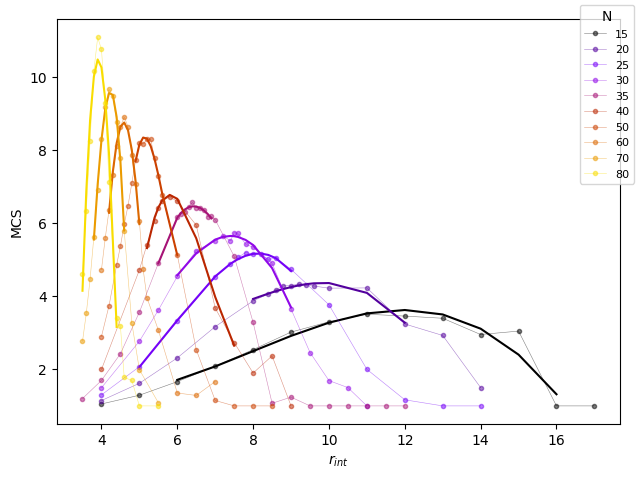

In [43]:
arena_r, exclusion_r, Ns = 20.0, 1.5, [15, 20, 25, 30, 35, 40, 50, 60, 70, 80]
around_maxs = [5,5,5,5,5,4,4,4,4,4]
ss = [1,2,7,3,3,3,3,3,3,3]

percs_from_spline_ar_20 = meanClusterSize_w_splines(arena_r, exclusion_r, Ns, around_maxs, ss)

[77.96947219 -0.69441139]


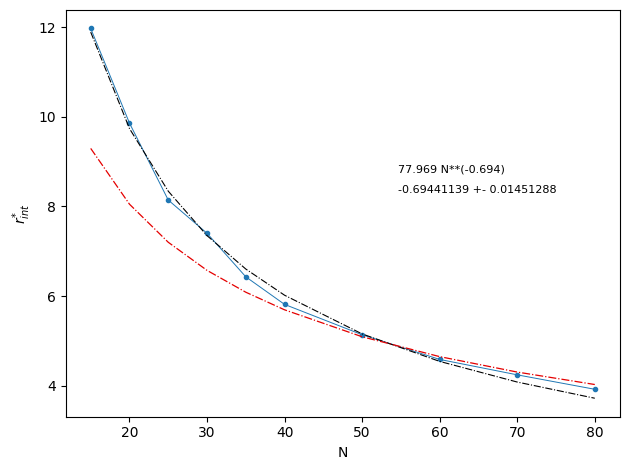

In [44]:
# def powerLaw(x,a,b,c):
#     return a*x**b + c
# paramfit = ri_star_N_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_20, powerLaw, p0in = (70.0, -0.6, 0.0))


def powerLaw(x,a,b):
    return a*x**b
paramfit = ri_star_N_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_20, powerLaw, eyerule=36)

print(paramfit)

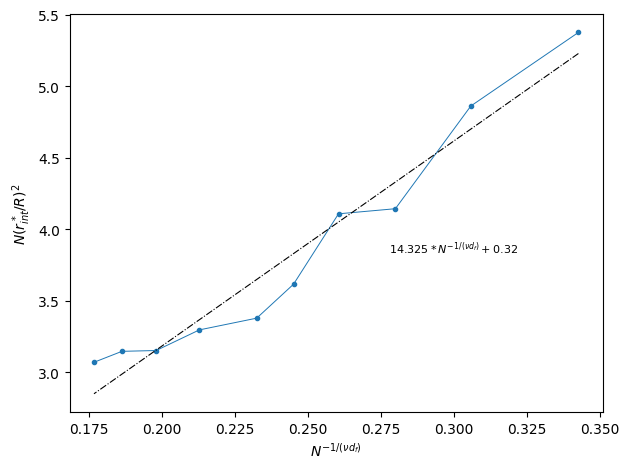

In [45]:
def linFunc(x,a,b):
    return a*x+b

p_star_FSC_check(arena_r, exclusion_r, Ns, percs_from_spline_ar_20, linFunc)

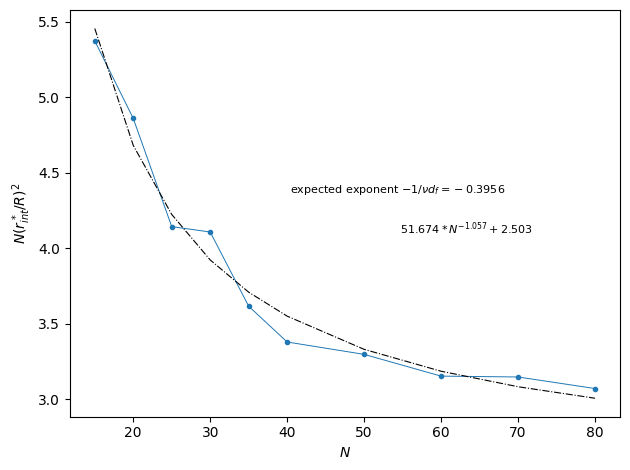

In [46]:
def powerLaw_pstar(N,a,b,c):
    return a*N**b + c

p_star_FSC_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_20, powerLaw_pstar, p0in=(20.0, -1.4, 1.0))

## arena 75.0, N around 492

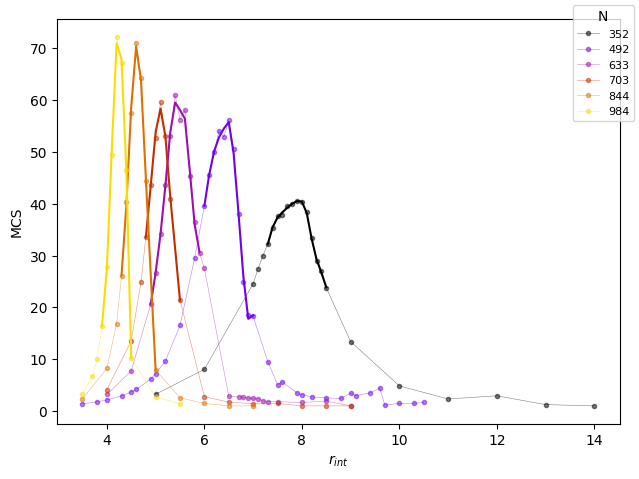

In [52]:
arena_r, exclusion_r, Ns = 75.0, 1.5, [352, 492, 633, 703, 844, 984]
ss = [1,7,10,3,3,3]
around_maxs = [6,5,5,3,3,3]

percs_from_spline_ar_75 = meanClusterSize_w_splines(arena_r, exclusion_r, Ns, around_maxs, ss)

[311.77408503  -0.62598094]


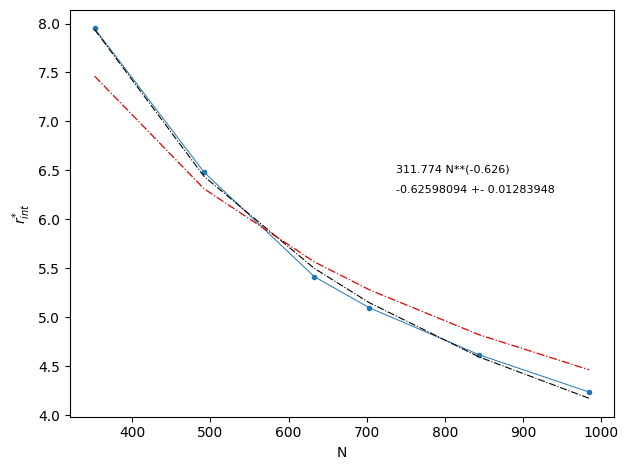

In [55]:
def powerLaw(x,a,b):
    return a*x**b
paramfit = ri_star_N_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_75, powerLaw, eyerule=140)

print(paramfit)

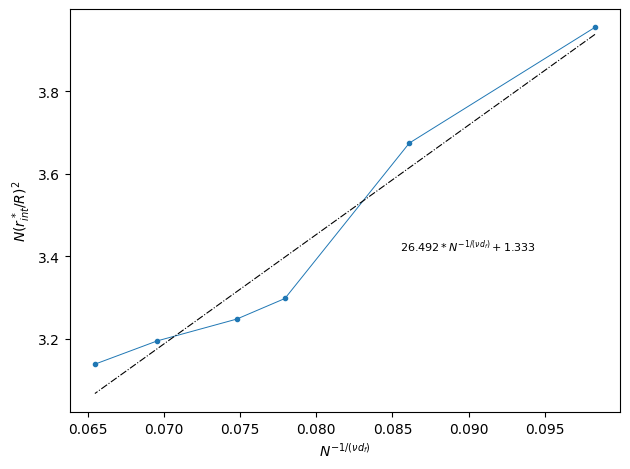

In [56]:
def linFunc(x,a,b):
    return a*x+b

p_star_FSC_check(arena_r, exclusion_r, Ns, percs_from_spline_ar_75, linFunc)

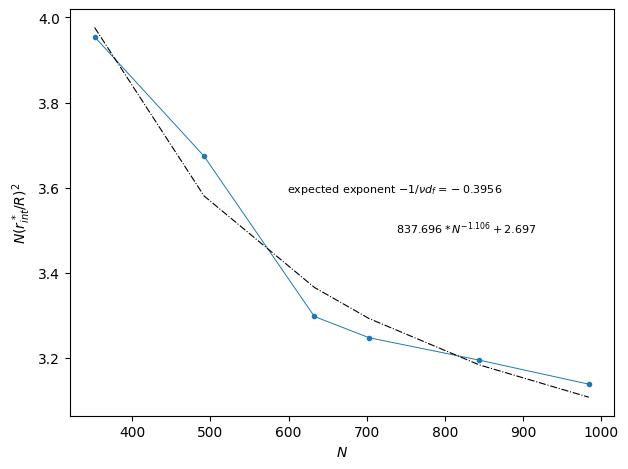

In [57]:
def powerLaw_pstar(N,a,b,c):
    return a*N**b + c

p_star_FSC_fit(arena_r, exclusion_r, Ns, percs_from_spline_ar_75, powerLaw_pstar, p0in=(20.0, -1.4, 1.0))

## Keeping the same density

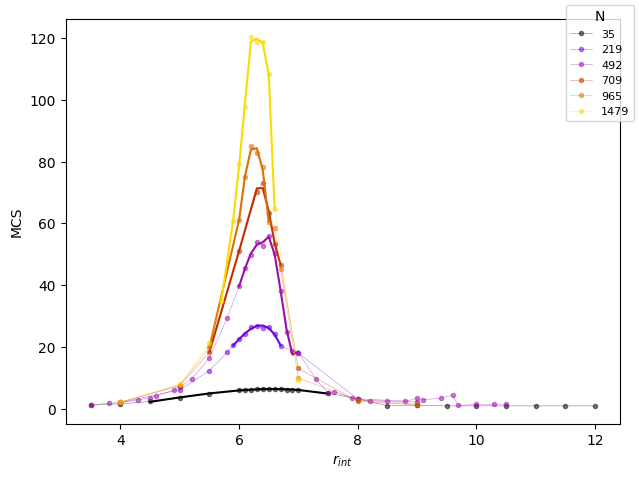

In [4]:
Ns = [35, 219, 492, 709, 965, 1479]
arena_rs = [20.0, 50.0, 75.0, 90.0, 105.0, 130.0]

exclusion_r = 1.5

ss = [1,3,5,5,5,5]
around_maxs = [7,4,5,3,3,4]

percs_from_spline_ar_same_dens = meanClusterSize_w_splines(arena_rs, exclusion_r, Ns, around_maxs, ss)

[ 6.87136979 -0.01227776]


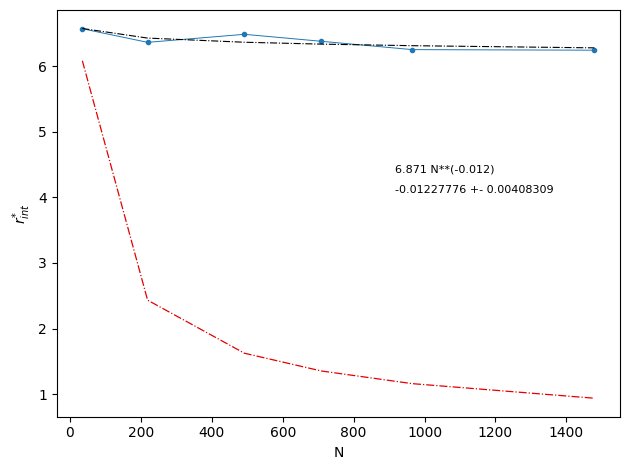

In [10]:
def powerLaw(x,a,b):
    return a*x**b

paramfit = ri_star_N_fit(arena_rs, exclusion_r, Ns, percs_from_spline_ar_same_dens, powerLaw, eyerule=36)

print(paramfit)

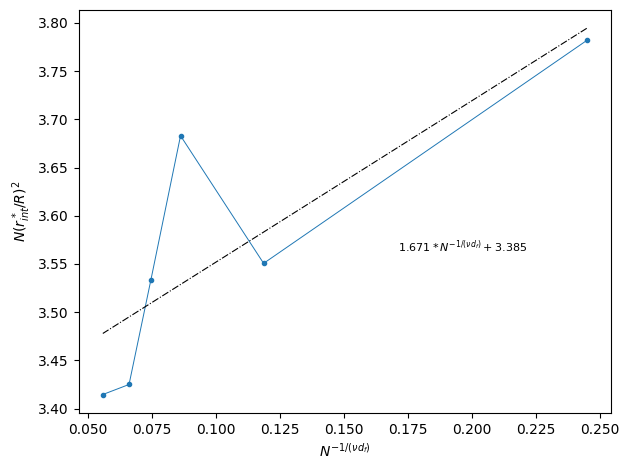

In [17]:
def linFunc(x,a,b):
    return a*x+b

p_star_FSC_check(arena_rs, exclusion_r, Ns, percs_from_spline_ar_same_dens, linFunc)

[-0.02776916  1.42460953]


[Text(0.5, 0, '$ln \\; N$'), Text(0, 0.5, '$ln \\; p$')]

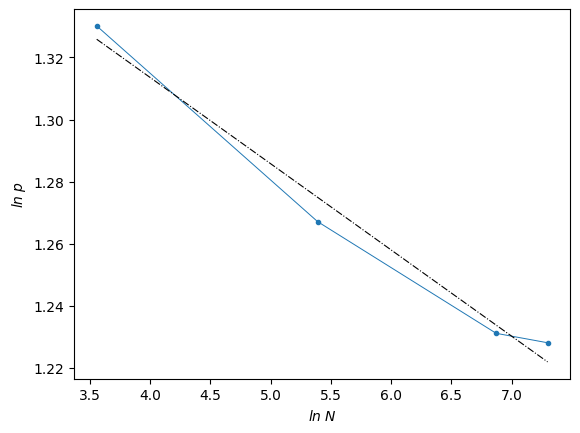

In [12]:
from scipy.optimize import curve_fit
y_axis = [N*(ri/ra)**2 for N,ri,ra in zip(Ns,percs_from_spline_ar_same_dens,arena_rs)]
y_axis_log = [np.log(y) for y in y_axis]
Ns_log = [np.log(N) for N in Ns]

Ns_log_corr = Ns_log[:2] + Ns_log[4:]
y_axis_log_corr = y_axis_log[:2] + y_axis_log[4:]

fig, ax = plt.subplots()
# ax.plot(Ns_log, y_axis_log, marker='.', lw=0.7)
ax.plot(Ns_log_corr, y_axis_log_corr, marker='.', lw=0.7)

def linFunc(x,a,b):
    return a*x + b

# paramfit, covfit = curve_fit(linFunc, Ns_log, y_axis_log)
paramfit, covfit = curve_fit(linFunc, Ns_log_corr, y_axis_log_corr)
fit = linFunc(np.array(Ns_log_corr), paramfit[0], paramfit[1])
ax.plot(Ns_log_corr, fit, ls='-.', lw=0.8, color='k')
print(paramfit)
ax.set(xlabel=r'$ln \; N$', ylabel=r'$ln \; p$')

In [ ]:
def powerLaw_pstar(N,a,b,c):
    return a*N**b + c

p_star_FSC_fit(arena_rs, exclusion_r, Ns, percs_from_spline_ar_same_dens, powerLaw_pstar, p0in=(20.0, -1.4, 1.0))